In [117]:
import scipy
import numpy as np
from corner import quantile
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import matplotlib
matplotlib.rcParams.update({
 "savefig.facecolor": "w",
 "figure.facecolor" : 'w',
 "figure.figsize" : (8,6),
 "text.color": "k",
 "legend.fontsize" : 20,
 "font.size" : 30,
 "axes.edgecolor": "k",
 "axes.labelcolor": "k",
 "axes.linewidth": 3,
 "xtick.color": "k",
 "ytick.color": "k",
 "xtick.labelsize" : 25,
 "ytick.labelsize" : 25,
 "ytick.major.size" : 12,
 "xtick.major.size" : 12,
 "ytick.major.width" : 2,
 "xtick.major.width" : 2,
 "font.family": 'STIXGeneral',
 "mathtext.fontset" : "cm"})
from PIL import Image
import statsmodels.api as sm

## An exercise in quantile mapping:

“Quantile mapping bias correction algorithms are commonly used to correct systematic distributional biases in precipitation outputs from climate models” (Cannon+2015)

Essentially, climate models are compared to historical observations over some medium- to long-term timescales (decades) so that the model projections can be corrected for any systematic bias. There are several ways to do bias corrections but a class of techniques generally called quantile mapping aim to preserve the characteristics of the observed trends (for, e.g., temps, this can mean the mean as well as the extreme values at the tails of the distribution) as well as include the long term trends in the climate models (these techniques are typically called quantile delta mapping).

Below I'll attempt to explore how these algorithms work.


## Quantile Delta Mapping

“[...] Quantile delta mapping (QDM), explicitly preserves relative changes in simulated precipitation quantiles from a climate model. Systematic distributional biases relative to observations in a historical baseline period are corrected by first detrending all projected future quantiles from a model and then applying quantile mapping to the detrended series. After detrending and quantile mapping, projected trends in the modeled quantiles are reintroduced on top of the bias-corrected outputs, thus ensuring that the climate sensitivity of the underlying climate model, at least so far as quantiles are concerned, is unaffected by the bias correction.” (Cannon+2015)

![qdm](https://journals.ametsoc.org/view/journals/clim/28/17/full-jcli-d-14-00754.1-f1.jpg)

First, for the projected model data, the outputs are detrended by their quantile (basically removing the effect of the climate model). This is done by finding the quantile of the projected output at some time and the same quantile in the historic model data (Eq. 3 in Cannon+2015) and then finding the relative change in the value (== delta quantile, Eq 4). Then the projected model quantile can be bias corrected from the observed values over the historical period (Eq. 5) which can then be applied to bias correct the projected value (Eq. 6).

## Exercise with Synthetic Data: Quantile Mapping

Following Cannon+15 (which itself follows Maurer & Pierce 2014), we assume the synthetic observations of precipitation and the climate model outputs both follow a gamma distribution,, 

In [424]:
mu = 30
std = 15
scale=7.5
synthetic_obs_dist = scipy.stats.gamma(a=mu/scale, scale=scale)
mu = 30
std = 10.5
scale=3.68
historical_model_dist = scipy.stats.gamma(a=mu/scale, scale=scale)
mu = 42
std = 10.5
scale=2.63
projected_model_dist = scipy.stats.gamma(a=mu/scale, scale=scale)
draws = np.linspace(0,100,10000)

obs_rvs = synthetic_obs_dist.rvs(len(draws))
hm_rvs = historical_model_dist.rvs(len(draws))
pm_rvs = projected_model_dist.rvs(len(draws))

obs_pdf = synthetic_obs_dist.pdf(draws)
hm_pdf = historical_model_dist.pdf(draws)
pm_pdf = projected_model_dist.pdf(draws)

In [410]:
print(synthetic_obs_dist.mean(),
historical_model_dist.mean(),
projected_model_dist.mean())

30.0 30.000000000000004 42.0


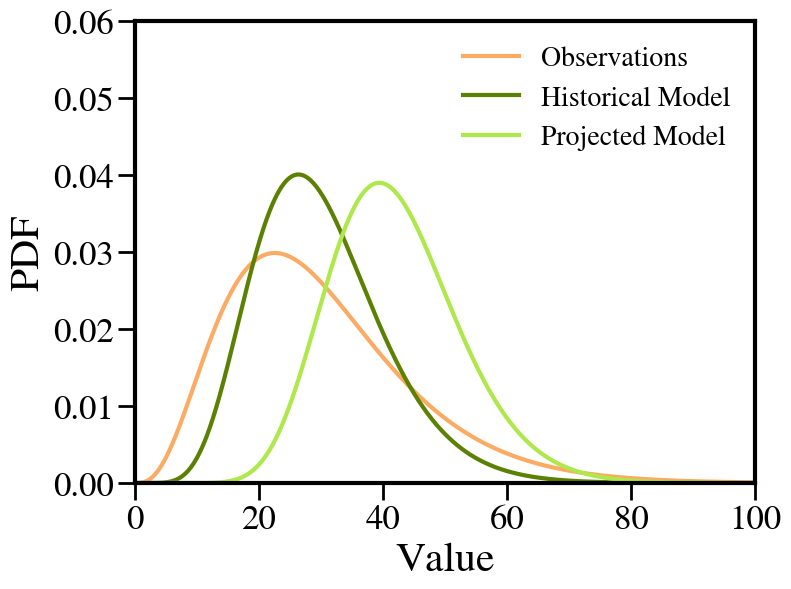

In [425]:
plt.plot(draws,obs_pdf, color='#FCAB64',lw=3, label='Observations')
plt.plot(draws,hm_pdf,color='#5C8001', lw=3, label='Historical Model')
plt.plot(draws,pm_pdf,color='#AEE84A', lw=3, label='Projected Model')
plt.ylabel('PDF')
plt.xlabel('Value')
plt.ylim([0,0.06])
plt.xlim([0,100])
plt.legend(frameon=False)

In this example, the observed and modeled data for the historical period have the same mean, but the GCM underestimates the observed standard deviation by 30%; the model projects a 40% increase in the mean for the future period, with no accompanying change in the standard deviation.

In [377]:
#define some time periods and gather data points
historical_time = np.arange(1971,2000,0.1)
projected_time = np.arange(2041, 2070, 0.05)

observations = synthetic_obs_dist.rvs(len(historical_time))
hist_model = historical_model_dist.rvs(len(historical_time))
proj_model = projected_model_dist.rvs(len(projected_time))

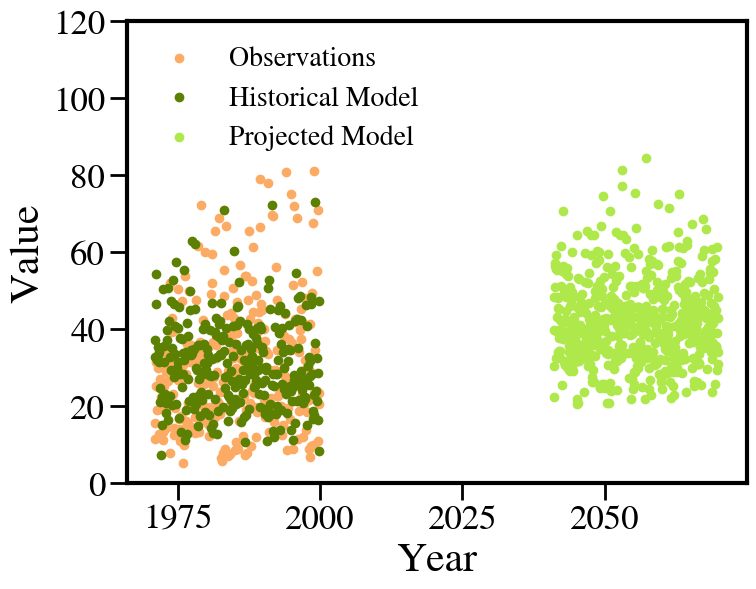

In [378]:
plt.scatter(historical_time, observations, color='#FCAB64',label='Observations')
plt.scatter(historical_time, hist_model,color='#5C8001', label='Historical Model')
plt.scatter(projected_time, proj_model,color='#AEE84A', label='Projected Model')

plt.xlabel('Year')
plt.ylabel('Value')
plt.ylim([0,120])
plt.legend(frameon=False)

In [345]:
#quantiles
perc = np.linspace(0,1,100)

obs_quantiles = quantile(observations, perc)
hist_mod_quantiles = quantile(hist_model, perc)
proj_mod_quantiles = quantile(proj_model, perc)

A Q–Q plot is used to compare the shapes of distributions, providing a graphical view of how properties such as location, scale, and skewness are similar or different in the two distributions. If the two distributions being compared are similar, the points in the Q–Q plot will approximately lie on the identity line y = x. If the distributions are linearly related, the points in the Q–Q plot will approximately lie on a line, but not necessarily on the line y = x. Although a Q–Q plot is based on quantiles, in a standard Q–Q plot it is not possible to determine which point in the Q–Q plot determines a given quantile. For example, it is not possible to determine the median of either of the two distributions being compared by inspecting the Q–Q plot.

In the below plot, we can see the effect of the different standard deviations (spread) between the observed and model historic data. We can use this information to correct the projected model assuming this difference holds for the future period.

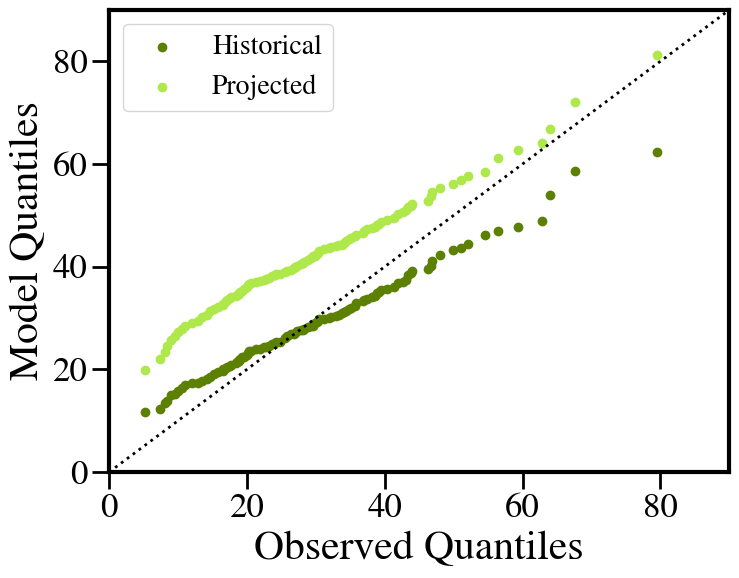

In [361]:
plt.scatter(obs_quantiles, hist_mod_quantiles, color='#5C8001', label='Historical')
plt.scatter(obs_quantiles, proj_mod_quantiles, color='#AEE84A', label='Projected')
plt.plot([0,100],[0,100], lw=2, ls=':', color='black')

plt.ylabel('Model Quantiles')
plt.xlabel('Observed Quantiles')
plt.ylim([0,90])
plt.xlim([0,90])
plt.legend()

If CDFs and inverse CDFs (i.e., quantile functions) are estimated empirically from the data, the algorithm can be illustrated with the aid of a quantile–quantile plot, which is the scatterplot between empirical quantiles of observed and modeled data (i.e., the sorted values in each sample when the number of observed and modeled samples are the same). In this case, QM amounts to a lookup table whose entries are found by interpolating between points in the quantile–quantile plot of the historical data. The transfer function is constructed using information from the historical period exclusively;

In [362]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.interpolate import interp1d

#quaanatile mapping
percentile = scipy.stats.percentileofscore(hist_model, proj_model)
corrected_proj_model_qm = np.percentile(observations, percentile)


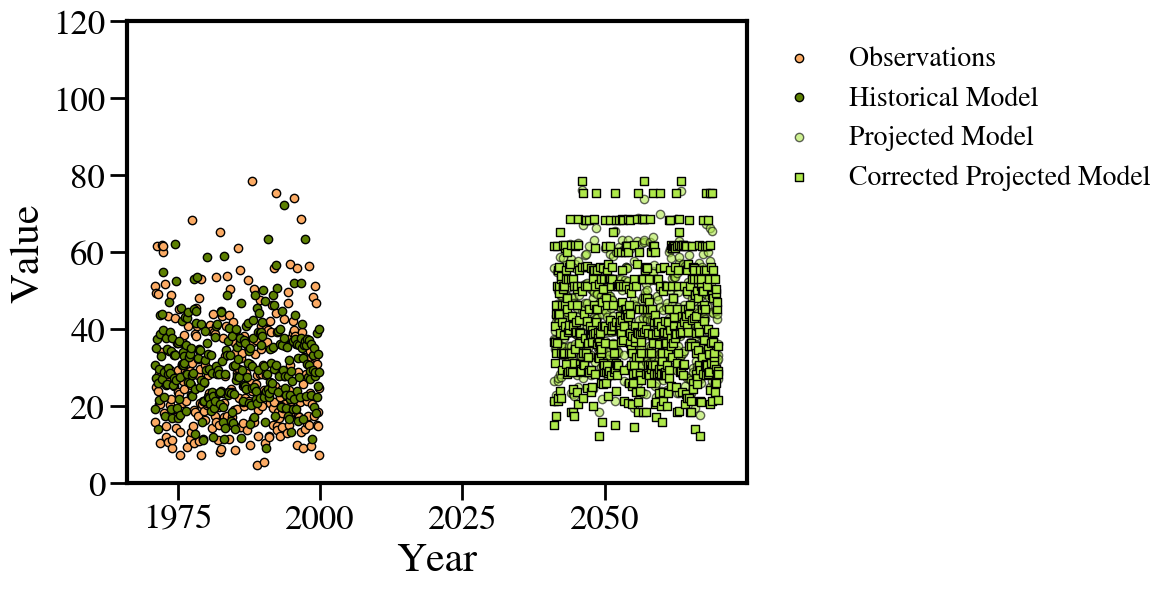

In [363]:
plt.scatter(historical_time, observations, edgecolor='black', color='#FCAB64',label='Observations')
plt.scatter(historical_time, hist_model,edgecolor='black',color='#5C8001', label='Historical Model')
plt.scatter(projected_time, proj_model,edgecolor='black',color='#AEE84A', alpha=0.6, label='Projected Model')
plt.scatter(projected_time, corrected_proj_model_qm, edgecolor='black',color='#AEE84A', marker='s', label='Corrected Projected Model')

plt.xlabel('Year')
plt.ylabel('Value')
plt.ylim([0,120])
plt.legend(frameon=False, bbox_to_anchor=(1,1))

In [411]:
np.mean(corrected_proj_model_qm), np.mean(proj_model), np.mean(observations)

(42.30217205482802, 42.083218757684705, 30.250110916051895)

In [412]:
np.std(corrected_proj_model_qm), np.std(proj_model)

(14.268299342202397, 10.75189395377604)

However, while the skew of the projected model aligns more with the historical data, the projected increase in the mean is no longer just ~40% but now at ~60%: As demonstrated by Maurer and Pierce (2014), underestimation of variance for a bounded, right-skewed variable will result in an amplification of projected trends in the mean by QM (and vice versa for overestimation of variance)

In [428]:
#now for the PDF
percentile = scipy.stats.percentileofscore(hm_pdf, pm_pdf)
corrected_proj_model_qm_pdf = np.percentile(obs_pdf, percentile)

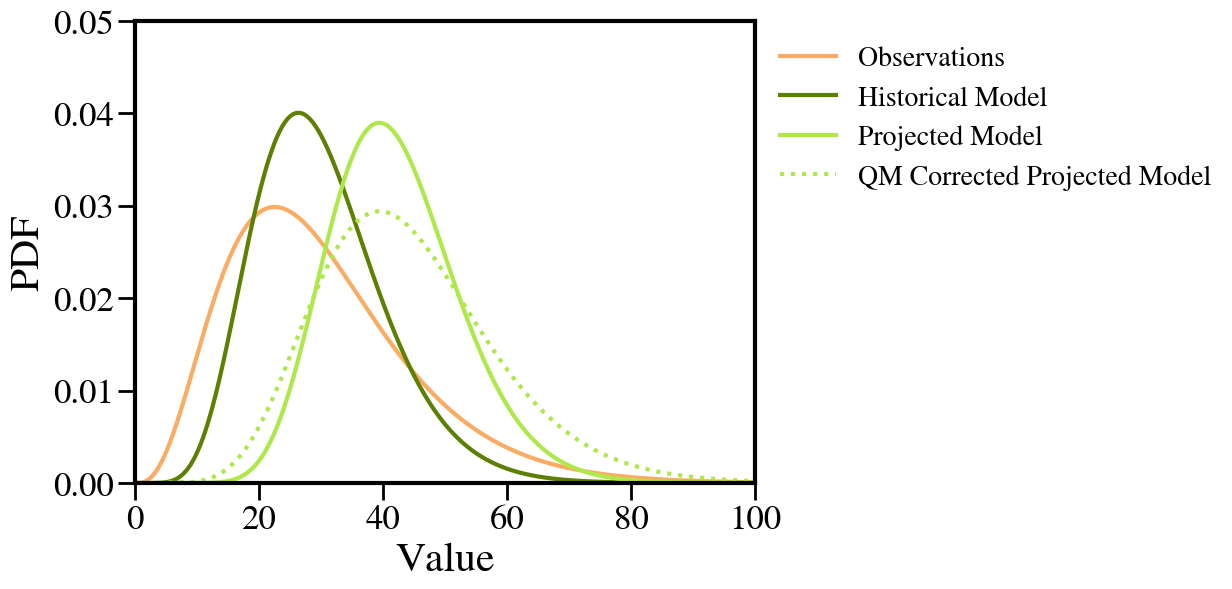

In [429]:
plt.plot(draws,obs_pdf, color='#FCAB64',lw=3, label='Observations')
plt.plot(draws,hm_pdf,color='#5C8001', lw=3, label='Historical Model')
plt.plot(draws,pm_pdf,color='#AEE84A', lw=3, label='Projected Model')
plt.plot(draws, corrected_proj_model_qm_pdf, color='#AEE84A', lw=3, ls=':', label='QM Corrected Projected Model')
plt.ylabel('PDF')
plt.xlabel('Value')
plt.ylim([0,0.05])
plt.xlim([0,100])
plt.legend(frameon=False, bbox_to_anchor=(1,1))

In [433]:
percentile = scipy.stats.percentileofscore(hm_rvs, pm_rvs)
corrected_proj_model_qm_rvs = np.percentile(obs_rvs, percentile)

In [431]:
print(projected_model_dist.mean(), np.mean(corrected_proj_model_qm_rvs))

42.0 47.59381018752006


In [434]:
print(projected_model_dist.std(), np.std(corrected_proj_model_qm_rvs))

10.509995242624994 16.021975148428375


Owing to the amplification of projected trends in the mean by QM, we can instead apply the detrended quantile mapping technique, which enables us to avoid extrapolating for values that lie outside of the historical data (like for the projected increase in the mean by 40%).

## Exercise with Synthetic Data: Detrended Quantile Mapping

In [394]:
#detrended quantile mapping

projected_mean = np.mean(proj_model)
historical_mean = np.mean(hist_model)

percentile = scipy.stats.percentileofscore(hist_model, (historical_mean/projected_mean)*proj_model)
corrected_proj_model_dqm = np.percentile(observations, percentile) * (projected_mean/historical_mean)


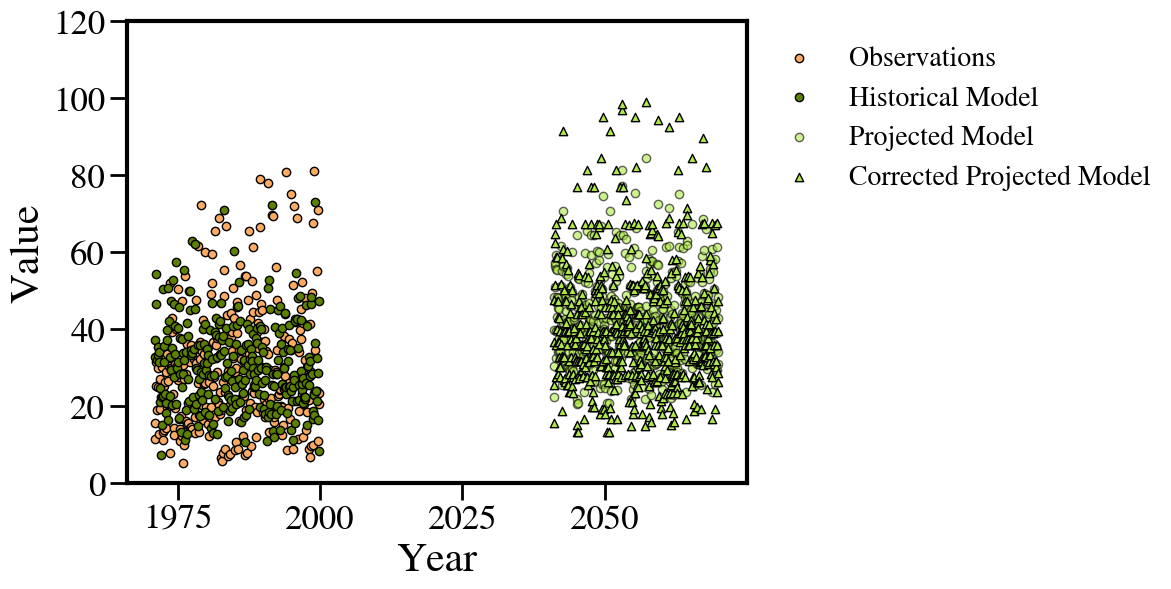

In [395]:
plt.scatter(historical_time, observations, edgecolor='black', color='#FCAB64',label='Observations')
plt.scatter(historical_time, hist_model,edgecolor='black',color='#5C8001', label='Historical Model')
plt.scatter(projected_time, proj_model,edgecolor='black',color='#AEE84A', alpha=0.6, label='Projected Model')
plt.scatter(projected_time, corrected_proj_model_dqm, edgecolor='black',color='#AEE84A', marker='^', label='Corrected Projected Model')

plt.xlabel('Year')
plt.ylabel('Value')
plt.ylim([0,120])
plt.legend(frameon=False, bbox_to_anchor=(1,1))

In [396]:
np.mean(corrected_proj_model_dqm), np.mean(proj_model), np.mean(observations)

(40.486572098932754, 42.083218757684705, 30.250110916051895)

In [397]:
np.std(corrected_proj_model_dqm), np.std(proj_model)

(15.650563571617173, 10.75189395377604)

In [435]:
percentile = scipy.stats.percentileofscore(hm_pdf, (historical_mean/projected_mean)*pm_pdf)
corrected_proj_model_dqm_pdf = np.percentile(obs_pdf, percentile) * (projected_mean/historical_mean)

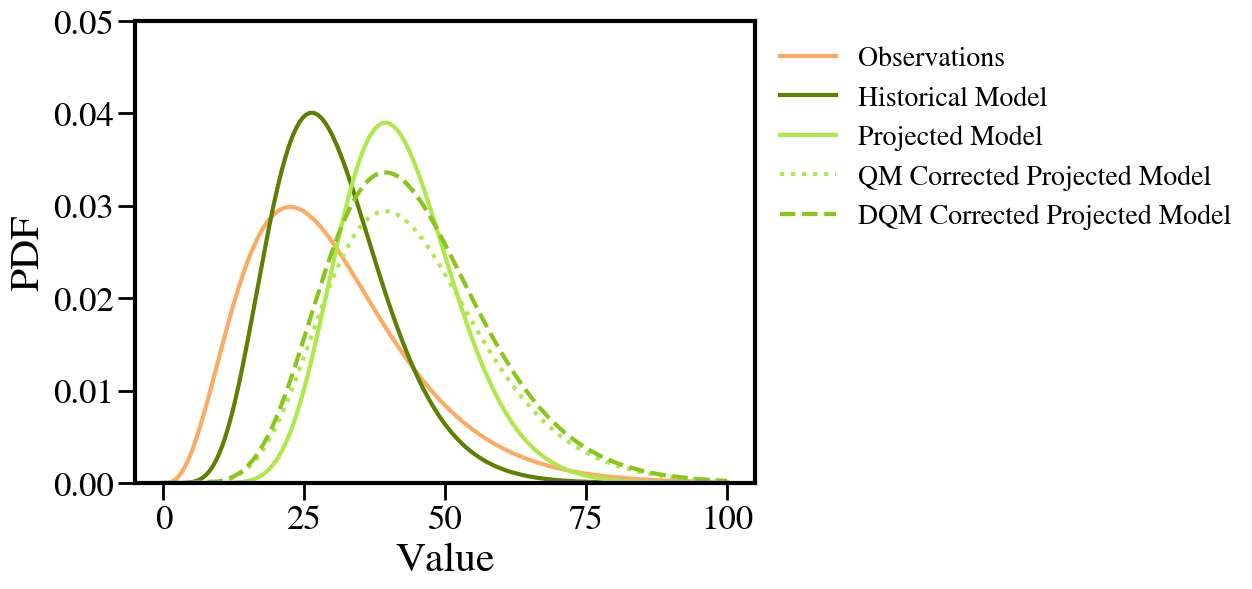

In [436]:
plt.plot(draws,obs_pdf, color='#FCAB64',lw=3, label='Observations')
plt.plot(draws,hm_pdf,color='#5C8001', lw=3, label='Historical Model')
plt.plot(draws,pm_pdf,color='#AEE84A', lw=3, label='Projected Model')
plt.plot(draws, corrected_proj_model_qm_pdf, color='#AEE84A', lw=3, ls=':', label='QM Corrected Projected Model')
plt.plot(draws, corrected_proj_model_dqm_pdf, color='#87C71A', lw=3, ls='--', label='DQM Corrected Projected Model')
plt.ylabel('PDF')
plt.xlabel('Value')
plt.ylim([0,0.05])
plt.legend(frameon=False, bbox_to_anchor=(1,1))

In [437]:
percentile = scipy.stats.percentileofscore(hm_rvs,(historical_mean/projected_mean)* pm_rvs)
corrected_proj_model_dqm_rvs = np.percentile(obs_rvs, percentile)* (projected_mean/historical_mean)

In [438]:
print(projected_model_dist.mean(), np.mean(corrected_proj_model_dqm_rvs))

42.0 42.168927292539884


In [439]:
print(projected_model_dist.std(),np.std(corrected_proj_model_dqm_rvs))

10.509995242624994 15.004924580108801


So now we more accurately match the mean of the uncorrected projected model but that is no guarantee that we can match all quantiles, like those in the tails of the distribution that define climate extremes...what we need is a way to preserve model-projected relative changes in quantiles at the same time correcting for systematic biases in quantiles of modeled data with respect to observations.

## Exercise with Synthetic Data: Quantile Delta Mapping